 1     Dataset Construction

Sinc Function Data with Noise

Data Generation and Visualization


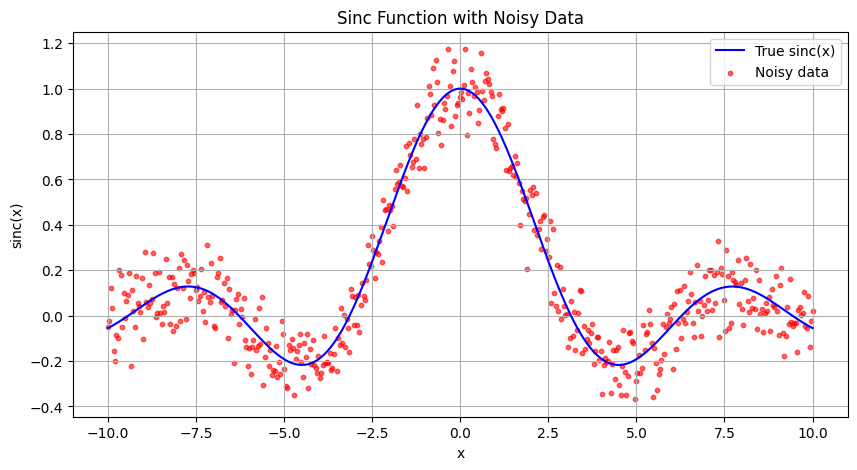

In [ ]:
import torch
import matplotlib.pyplot as plt

# 1.1.1 Data Generation
# Generating 1D input values
x = torch.linspace(-10, 10, 500)

# Computing sinc(x) = sin(x)/x with handling x=0 case
sinc_true = torch.where(x == 0, torch.tensor(1.0), torch.sin(x) / x)

# Adding Gaussian noise
noise = 0.1 * torch.randn(x.size())  # scale noise as needed
sinc_noisy = sinc_true + noise

# 1.1.2 Visualization
plt.figure(figsize=(10, 5))
plt.plot(x.numpy(), sinc_true.numpy(), label="True sinc(x)", color='blue')
plt.scatter(x.numpy(), sinc_noisy.numpy(), label="Noisy data", color='red', s=10, alpha=0.6)
plt.xlabel("x")
plt.ylabel("sinc(x)")
plt.title("Sinc Function with Noisy Data")
plt.legend()
plt.grid(True)
plt.show()


2  Multilayer Perceptron (MLP) with Two Hidden Layers

Model Architecture and Setup

Training the MLP

Decision Boundary Visualization

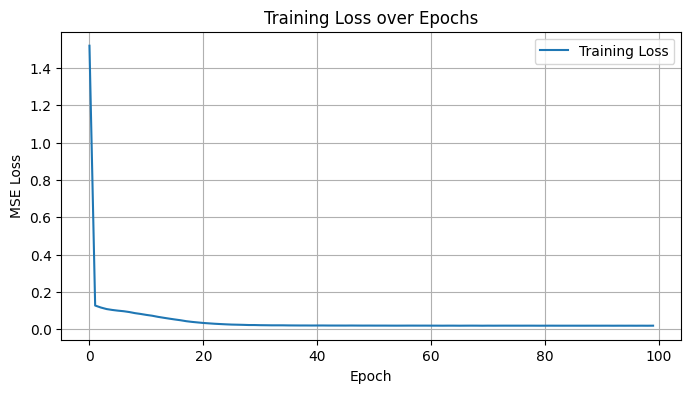

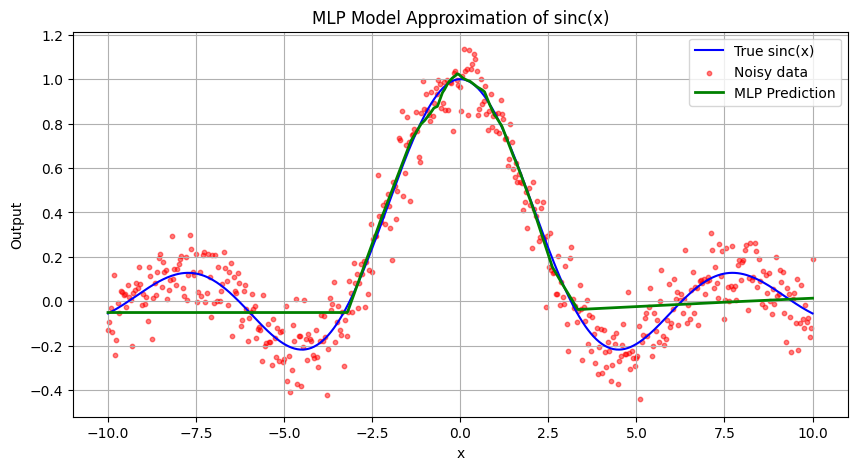

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# 2.1 Model Architecture and Setup
# 2.1.1 Defining the MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 2.1.2 Hyperparameters and Setup
batch_size = 64
learning_rate = 0.05
num_epochs = 100
loss_fn = nn.MSELoss()

# 2.2 Training the MLP
# 2.2.1 Data Preparation
x_tensor = x.view(-1, 1)  # Shape: (N, 1)
y_tensor = sinc_noisy.view(-1, 1)

# Wrap the data using TensorDataset and DataLoader
dataset = TensorDataset(x_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 2.2.2 Training Loop
training_loss = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in loader:
        preds = model(batch_x)
        loss = loss_fn(preds, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    training_loss.append(avg_loss)

# 2.2.3 Visualization of Training Loss
plt.figure(figsize=(8,4))
plt.plot(range(num_epochs), training_loss, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# 2.3 Decision Boundary Visualization (Predictions Over Grid)
#  2.3.1 Generate a dense grid of input values
x_grid = np.linspace(-10, 10, 1000).reshape(-1, 1)
x_grid_tensor = torch.tensor(x_grid, dtype=torch.float32)

# 2.3.2 PredictionovertheGrid
model.eval()
with torch.no_grad():
    y_pred_grid = model(x_grid_tensor)

# Convert for plotting
x_grid_np = x_grid_tensor.numpy().flatten()
y_pred_np = y_pred_grid.numpy().flatten()

# Visualization
plt.figure(figsize=(10,5))
plt.plot(x.numpy(), sinc_true.numpy(), label="True sinc(x)", color='blue')
plt.scatter(x.numpy(), sinc_noisy.numpy(), label="Noisy data", color='red', s=10, alpha=0.5)
plt.plot(x_grid_np, y_pred_np, label="MLP Prediction", color='green', linewidth=2)
plt.xlabel("x")
plt.ylabel("Output")
plt.title("MLP Model Approximation of sinc(x)")
plt.legend()
plt.grid(True)
plt.show()


 3   Introduction to CNN with PyTorch

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/rockpaperscissors


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

class RockPaperScissorsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.classes = ['rock', 'paper', 'scissors']
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_folder = os.path.join(root_dir, class_name)
            if os.path.exists(class_folder):
                for file_name in os.listdir(class_folder):
                    if file_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(class_folder, file_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [84]:
import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Debug path
print("Downloaded path:", path)
print("Folder contents:", os.listdir(path))

# Choose correct subfolder
if 'rockpaperscissors' in os.listdir(path):
    dataset_path = os.path.join(path, 'rockpaperscissors')
else:
    dataset_path = path  # already contains class folders

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Dataset class (already defined earlier)
full_dataset = RockPaperScissorsDataset(root_dir=dataset_path, transform=transform)

print("Total images found:", len(full_dataset))  # should be > 0

# Split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f" Train samples: {len(train_dataset)}")
print(f" Test samples:  {len(test_dataset)}")


Downloaded path: /kaggle/input/rockpaperscissors
Folder contents: ['paper', 'rock', 'rps-cv-images', 'README_rpc-cv-images.txt', 'scissors']
Total images found: 2188
 Train samples: 1750
 Test samples:  438


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Basic CNN with 1 Conv layer
class SimpleCNN(nn.Module):
    def __init__(self, kernel=None, kernel_size=3, stride=1, padding=1):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=kernel_size,
                              stride=stride, padding=padding, bias=False)
        if kernel is not None:
            with torch.no_grad():
                self.conv.weight.copy_(kernel)

    def forward(self, x):
        return self.conv(x)


In [ ]:
# Get one image from your dataset
sample_image, _ = full_dataset[0]
print("Sample shape before Conv:", sample_image.shape)  # should be [3, 128, 128]


Sample shape before Conv: torch.Size([3, 128, 128])


In [ ]:
# Define blur kernel
blur = torch.tensor([[[[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]]]], dtype=torch.float32) / 9.0

# Define edge detection kernel
edge = torch.tensor([[[[-1, -1, -1],
                       [-1, 8, -1],
                       [-1, -1, -1]]]], dtype=torch.float32)

# Define sharpen kernel
sharpen = torch.tensor([[[[0, -1, 0],
                          [-1, 5, -1],
                          [0, -1, 0]]]], dtype=torch.float32)

# Expand each kernel to shape [out_channels, in_channels, kH, kW]
def expand_kernel(k):
    return k.expand(1, 3, 3, 3)  # 3 input channels, 1 output


In [ ]:
def visualize_feature_map(image, model, title):
    image = image.unsqueeze(0)  # Add batch dimension: [1, 3, H, W]
    with torch.no_grad():
        output = model(image)
    output_image = output[0][0].cpu()  # Get single feature map
    plt.imshow(output_image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


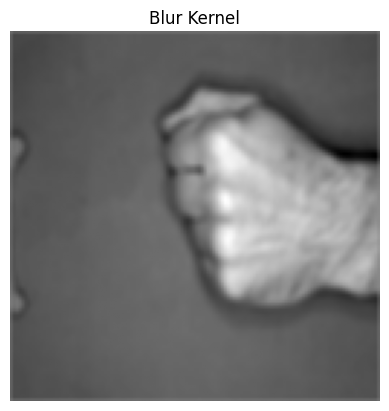

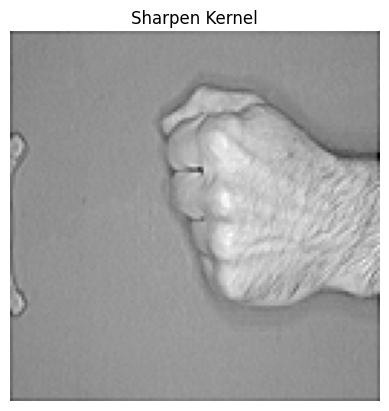

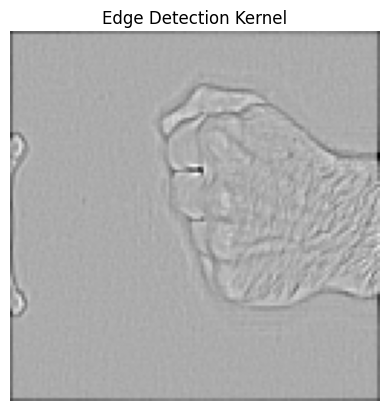

In [ ]:
# Blur
blur_model = SimpleCNN(kernel=expand_kernel(blur))
visualize_feature_map(sample_image, blur_model, "Blur Kernel")

# Sharpen
sharpen_model = SimpleCNN(kernel=expand_kernel(sharpen))
visualize_feature_map(sample_image, sharpen_model, "Sharpen Kernel")

# Edge
edge_model = SimpleCNN(kernel=expand_kernel(edge))
visualize_feature_map(sample_image, edge_model, "Edge Detection Kernel")


In [ ]:
# Larger kernel (5x5), stride=2, padding=2 (to preserve size)
model_custom = SimpleCNN(kernel_size=5, stride=2, padding=2)
output = model_custom(sample_image.unsqueeze(0))
print("Output shape with kernel=5, stride=2, padding=2:", output.shape)


Output shape with kernel=5, stride=2, padding=2: torch.Size([1, 1, 64, 64])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNNWithMaxPool(nn.Module):
    def __init__(self):
        super(CNNWithMaxPool, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        conv_out = F.relu(self.conv(x))       # Feature map
        pooled_out = self.pool(conv_out)      # After pooling
        return conv_out, pooled_out


In [ ]:
model = CNNWithMaxPool()

# Convert image to batch format
input_tensor = sample_image.unsqueeze(0)  # [1, 3, 128, 128]

# Get outputs
with torch.no_grad():
    features_before, features_after = model(input_tensor)

print("Before pooling:", features_before.shape)  # e.g., [1, 4, 128, 128]
print("After pooling: ", features_after.shape)   # e.g., [1, 4, 64, 64]


Before pooling: torch.Size([1, 4, 128, 128])
After pooling:  torch.Size([1, 4, 64, 64])


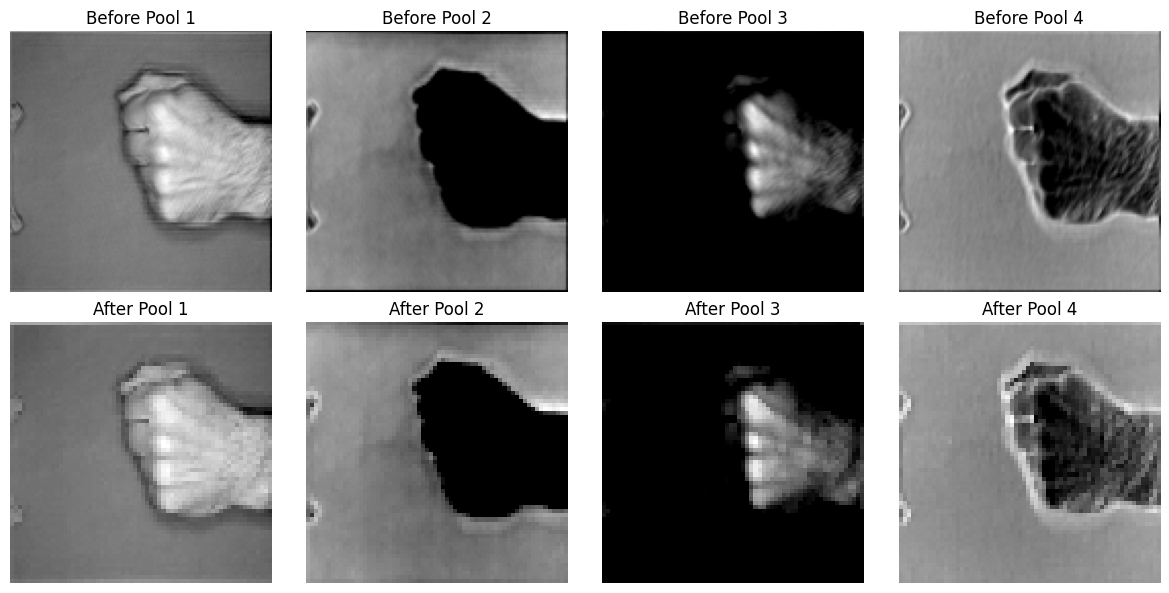

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_maps(before, after):
    fig, ax = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(4):
        ax[0][i].imshow(before[0][i].cpu(), cmap='gray')
        ax[0][i].set_title(f'Before Pool {i+1}')
        ax[0][i].axis('off')
        ax[1][i].imshow(after[0][i].cpu(), cmap='gray')
        ax[1][i].set_title(f'After Pool {i+1}')
        ax[1][i].axis('off')
    plt.tight_layout()
    plt.show()

plot_feature_maps(features_before, features_after)


In [ ]:
class CNNWithGAP(nn.Module):
    def __init__(self):
        super(CNNWithGAP, self).__init__()
        self.conv = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Output shape: [batch, channels, 1, 1]

    def forward(self, x):
        conv_out = F.relu(self.conv(x))
        gap_out = self.gap(conv_out)
        return conv_out, gap_out


In [ ]:
gap_model = CNNWithGAP()
with torch.no_grad():
    conv_out, gap_out = gap_model(input_tensor)

print("Conv output shape: ", conv_out.shape)  # [1, 8, 128, 128]
print("GAP output shape:  ", gap_out.shape)   # [1, 8, 1, 1]


Conv output shape:  torch.Size([1, 8, 128, 128])
GAP output shape:   torch.Size([1, 8, 1, 1])


In [74]:
import torch.nn as nn
import torch.nn.functional as F

class CompleteCNN(nn.Module):
    def __init__(self):
        super(CompleteCNN, self).__init__()
        # Convolutional blocks
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # -> [B, 16, 128, 128]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # -> [B, 32, 64, 64]
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # -> [B, 64, 32, 32]
        self.pool = nn.MaxPool2d(2, 2)

        # Global Average Pooling -> [B, 64, 1, 1]
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected MLP
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 3)  # 3 output classes

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [75]:
model = CompleteCNN()

# Use one image from the dataset (batch of 1)
input_tensor = sample_image.unsqueeze(0)  # [1, 3, 128, 128]

# Forward pass and shape trace
output = model(input_tensor)



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [76]:
# Training parameters
learning_rate = 0.1
batch_size = 16
num_epochs = 30

# Loaders (if not created yet)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [77]:
# Initialize model, loss, and optimizer
model = CompleteCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


In [78]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * (correct / total)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation
    model.eval()
    test_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * (correct / total)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}: "
          f"Train Acc = {train_accuracy:.2f}, Train Loss = {avg_train_loss:.4f} | "
          f"Test Acc = {test_accuracy:.2f}, Test Loss = {avg_test_loss:.4f}")


Epoch 1: Train Acc = 34.51, Train Loss = 1.0987 | Test Acc = 34.93, Test Loss = 1.0986
Epoch 2: Train Acc = 35.54, Train Loss = 1.0990 | Test Acc = 34.93, Test Loss = 1.0957
Epoch 3: Train Acc = 35.43, Train Loss = 1.0953 | Test Acc = 33.11, Test Loss = 1.0960
Epoch 4: Train Acc = 38.63, Train Loss = 1.0797 | Test Acc = 47.72, Test Loss = 1.0531
Epoch 5: Train Acc = 43.89, Train Loss = 1.0396 | Test Acc = 39.95, Test Loss = 1.0301
Epoch 6: Train Acc = 43.71, Train Loss = 1.0178 | Test Acc = 32.42, Test Loss = 1.2918
Epoch 7: Train Acc = 49.26, Train Loss = 1.0003 | Test Acc = 45.89, Test Loss = 0.9807
Epoch 8: Train Acc = 50.69, Train Loss = 0.9698 | Test Acc = 51.14, Test Loss = 0.9250
Epoch 9: Train Acc = 54.91, Train Loss = 0.9037 | Test Acc = 73.74, Test Loss = 0.8020
Epoch 10: Train Acc = 71.43, Train Loss = 0.7017 | Test Acc = 65.75, Test Loss = 0.6099
Epoch 11: Train Acc = 79.83, Train Loss = 0.5137 | Test Acc = 73.06, Test Loss = 0.5828
Epoch 12: Train Acc = 90.17, Train Loss =

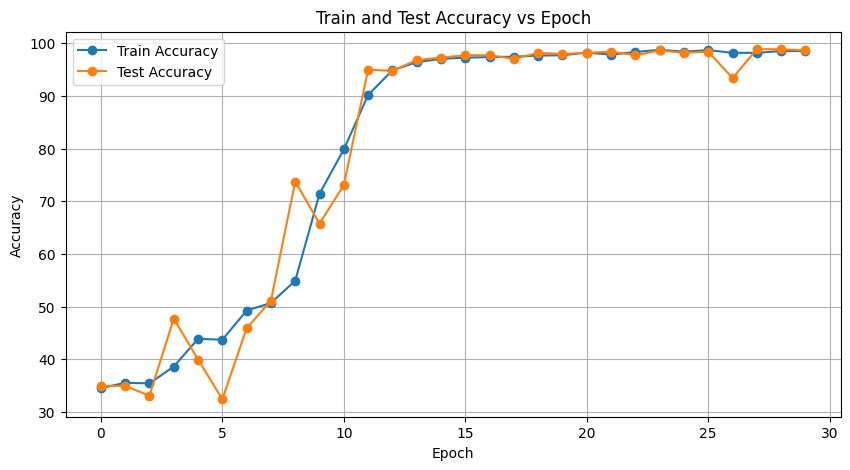

In [83]:
# Accuracy plot
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy vs Epoch")
plt.grid(True)
plt.legend()


plt.show()


The learning rate controls how quickly the model updates its weights. A very small learning rate can make training slow and inefficient, while a large learning rate may cause the model to overshoot and not converge properly. A moderate value (like 0.01) often results in stable and efficient training.

The batch size affects how much data the model sees before updating weights. Smaller batches can help generalization but lead to noisier updates, while larger batches provide more stable learning but may overfit or train slower overall. A batch size between 32 and 64 usually works well.

The number of epochs determines how many times the model sees the entire dataset. Too few epochs can cause underfitting, while too many may lead to overfitting. Monitoring performance on the test set helps decide when to stop training.